# **IE Sustainability Datathon 2023:** 04b_ML Models (15mins - XGBoost)

## 0. GENERAL CONFIG

### Modules & Libraries

In [ ]:
#conda update scikit-learn

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
# IMPORT MODULES

# Base -----------------------------------------------------------
import pandas as pd
import numpy as np
import pathlib
import datetime as dt
from scipy.stats import norm
from datetime import datetime
#import pandas_profiling
from math import *

pd.options.display.float_format = "{:,.4f}".format

# Viz ------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.colors as ma
import matplotlib.font_manager as fm
import seaborn as sns
import plotly
import plotnine
from plotnine import *
#import patchworklib as pw

%matplotlib inline

In [ ]:
import time
from datetime import timedelta

In [ ]:
import sklearn
import matplotlib
import scipy
import statsmodels
import mlxtend
import category_encoders
import seaborn
import xgboost

In [ ]:
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OrdinalEncoder
from category_encoders import OrdinalEncoder

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
import optuna

In [ ]:
#importing all the plot functions
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

### Prepared Functions

In [ ]:
def miss_info(df_data):

    # MISSING VALUES INFO (BY COLUMNS)

    df_colsnan = pd.DataFrame()
    df_colsnan['dtypes'] = df_data.apply(lambda x: x.dtypes)
    df_colsnan['nan'] = df_data.isnull().sum()
    df_colsnan['perc_nan'] = (df_data.isnull().sum() / df_data.shape[0]) * 100
    df_colsnan['perc_nan'] = df_colsnan['perc_nan'].round(2)
    df_colsnan['not_nan'] = df_data.notnull().sum()
    df_colsnan['perc_not_nan'] = (df_data.notnull().sum() / df_data.shape[0]) * 100
    df_colsnan['perc_not_nan'] = df_colsnan['perc_not_nan'].round(2)
    df_colsnan['unique_values'] = df_data.apply(lambda x: len(x.unique()) )
    df_colsnan['neg_values'] = df_data.apply(lambda x: x.lt(0).sum() if x.dtypes == 'float64' else 'NA')
    df_colsnan.reset_index(inplace=True)
    df_colsnan.rename(columns={'index':'col_name'}, inplace=True)

    return df_colsnan

In [ ]:
def RowKey_transf(x):
    myDate = str(x.date())
    return dt.datetime.strptime(myDate, '%Y-%m-%d').strftime('%Y-%m-%dT00:00:00.000Z')

In [ ]:
def mape_corr(y_true, y_pred):

  mape_value = mean_absolute_percentage_error(y_true, y_pred)
  if mape_value > 1500 and (y_true-y_pred).mean()<1:
    mape_value = 0

  return mape_value

### General info & Code

In [ ]:
'''
cat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)

num_vars = list(df_model.select_dtypes(include=["number"]).columns)


# DATE COLUMN
df_model['settlementDate'] = pd.to_datetime(df_model['settlementDate'])


# Transforming date to CATEGORICAL ORDINAL
order = list(df_model['settlementDate'].unique())
order.sort()
data = df_model['settlementDate']
df_model['settlementDate'] = pd.Categorical(data, order, ordered=True)


# CATEGORICAL NOMINAL
# Column "recordtype"
data = df_model['recordtype']
df_model['recordtype'] = pd.Categorical(data, ordered=False)


'''

'\ncat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)\n\nnum_vars = list(df_model.select_dtypes(include=["number"]).columns)\n\n\n# DATE COLUMN\ndf_model[\'settlementDate\'] = pd.to_datetime(df_model[\'settlementDate\'])\n\n\n# Transforming date to CATEGORICAL ORDINAL\norder = list(df_model[\'settlementDate\'].unique())\norder.sort()\ndata = df_model[\'settlementDate\']\ndf_model[\'settlementDate\'] = pd.Categorical(data, order, ordered=True)\n\n\n# CATEGORICAL NOMINAL\n# Column "recordtype"\ndata = df_model[\'recordtype\']\ndf_model[\'recordtype\'] = pd.Categorical(data, ordered=False)\n\n\n'

## 1. LOADING & PREPARING DATASET

### Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/GDrive')

Mounted at /content/GDrive


In [ ]:
file_path = "/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1mins76 (IMPUTED).csv"

In [ ]:
df_1mins76 = pd.read_csv(file_path)
df_1mins76

,RowKey,RowKey_Date,RowKey_Time,DiaSem,Clasif_Lab,Clasif_Fest,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02 00:15:00+00:00,2021-08-02,00:15:00,Lunes,Laborable,No Festivo,2,8,2021,0,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-02 00:30:00+00:00,2021-08-02,00:30:00,Lunes,Laborable,No Festivo,2,8,2021,0,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
2,2021-08-02 00:45:00+00:00,2021-08-02,00:45:00,Lunes,Laborable,No Festivo,2,8,2021,0,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
3,2021-08-02 01:00:00+00:00,2021-08-02,01:00:00,Lunes,Laborable,No Festivo,2,8,2021,0,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
4,2021-08-02 01:15:00+00:00,2021-08-02,01:15:00,Lunes,Laborable,No Festivo,2,8,2021,0,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47707,2022-12-11 23:00:00+00:00,2022-12-11,23:00:00,Domingo,No Laborable,No Festivo,11,12,2022,0,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47708,2022-12-11 23:15:00+00:00,2022-12-11,23:15:00,Domingo,No Laborable,No Festivo,11,12,2022,0,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47709,2022-12-11 23:30:00+00:00,2022-12-11,23:30:00,Domingo,No Laborable,No Festivo,11,12,2022,0,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47710,2022-12-11 23:45:00+00:00,2022-12-11,23:45:00,Domingo,No Laborable,No Festivo,11,12,2022,0,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1


In [ ]:
df_1mins76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47712 entries, 0 to 47711
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RowKey                 47712 non-null  object 
 1   RowKey_Date            47712 non-null  object 
 2   RowKey_Time            47712 non-null  object 
 3   DiaSem                 47712 non-null  object 
 4   Clasif_Lab             47712 non-null  object 
 5   Clasif_Fest            47712 non-null  object 
 6   N_DiaMes               47712 non-null  int64  
 7   N_Mes                  47712 non-null  int64  
 8   N_Ano                  47712 non-null  int64  
 9   Lab_PrevioFest         47712 non-null  int64  
 10  Lab_PostFest           47712 non-null  int64  
 11  DiaSem_SIN             47712 non-null  float64
 12  DiaSem_COS             47712 non-null  float64
 13  Dia_SIN                47712 non-null  float64
 14  Dia_COS                47712 non-null  float64
 15  Me

In [ ]:
df_1mins76.describe()

,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,Lab_PostFest,DiaSem_SIN,DiaSem_COS,Dia_SIN,Dia_COS,Mes_SIN,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
count,"47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000",...,"47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000"
mean,15.5433,7.3722,"2,021.6942",0.0201,0.0282,-0.0000,-0.0000,0.0152,0.0074,-0.2107,...,0.6419,328.0455,"1,018.1833",6.5783,57.8959,2.1702,0.6217,0.3139,0.1590,0.0624
std,8.8154,3.3376,0.4608,0.1404,0.1655,0.7071,0.7071,0.7089,0.7051,0.7045,...,3.0996,122.8229,5.4755,4.0857,21.1428,7.3606,0.4850,0.4641,0.3656,0.2418
min,1.0000,1.0000,"2,021.0000",0.0000,0.0000,-0.9749,-0.9010,-1.0000,-1.0000,-1.0000,...,0.0000,55.1000,"1,001.8000",-6.4000,10.4900,0.0000,0.0000,0.0000,0.0000,0.0000
25%,8.0000,5.0000,"2,021.0000",0.0000,0.0000,-0.7818,-0.9010,-0.7248,-0.6691,-0.8660,...,0.0000,243.4000,"1,014.3000",3.9000,39.5300,0.0000,0.0000,0.0000,0.0000,0.0000
50%,15.0000,8.0000,"2,022.0000",0.0000,0.0000,0.0000,-0.2225,0.0000,-0.0506,-0.5000,...,0.0000,341.2000,"1,017.7000",6.9000,60.0000,0.0000,1.0000,0.0000,0.0000,0.0000
75%,23.0000,10.0000,"2,022.0000",0.0000,0.0000,0.7818,0.6235,0.7248,0.6890,0.5000,...,0.0000,436.6000,"1,021.5000",9.2000,76.1700,0.0000,1.0000,1.0000,0.0000,0.0000
max,31.0000,12.0000,"2,022.0000",1.0000,1.0000,0.9749,1.0000,1.0000,1.0000,1.0000,...,37.2000,557.6000,"1,033.1000",16.7000,97.7800,79.1700,1.0000,1.0000,1.0000,1.0000


### Dataset preparation

In [ ]:
df_1mins76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47712 entries, 0 to 47711
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RowKey                 47712 non-null  object 
 1   RowKey_Date            47712 non-null  object 
 2   RowKey_Time            47712 non-null  object 
 3   DiaSem                 47712 non-null  object 
 4   Clasif_Lab             47712 non-null  object 
 5   Clasif_Fest            47712 non-null  object 
 6   N_DiaMes               47712 non-null  int64  
 7   N_Mes                  47712 non-null  int64  
 8   N_Ano                  47712 non-null  int64  
 9   Lab_PrevioFest         47712 non-null  int64  
 10  Lab_PostFest           47712 non-null  int64  
 11  DiaSem_SIN             47712 non-null  float64
 12  DiaSem_COS             47712 non-null  float64
 13  Dia_SIN                47712 non-null  float64
 14  Dia_COS                47712 non-null  float64
 15  Me

In [ ]:
df_1mins76.columns

Index(['RowKey', 'RowKey_Date', 'RowKey_Time', 'DiaSem', 'Clasif_Lab',
       'Clasif_Fest', 'N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest',
       'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS',
       'Mes_SIN', 'Mes_COS', 'V_Carretera-Urda', 'V_Centro', 'V_Churruca',
       'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
       'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint',
       'precip', 'solarradiation', 'sealevelpressure', 'dew', 'humidity',
       'precipcover', 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain',
       'cond_Overcast'],
      dtype='object')

In [ ]:
selcols_order = ['RowKey', 'RowKey_Date', 'RowKey_Time', 'V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
                 'DiaSem', 'Clasif_Lab', 'Clasif_Fest','N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest',
                 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS','Mes_SIN', 'Mes_COS',
                 'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint', 'precip', 'solarradiation', 'sealevelpressure',
                 'dew', 'humidity', 'precipcover', 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast']

In [ ]:
df_1mins76 = df_1mins76[selcols_order].copy()
df_1mins76

,RowKey,RowKey_Date,RowKey_Time,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02 00:15:00+00:00,2021-08-02,00:15:00,1.1001,1.5938,11.1875,1.5978,2.7969,1.7121,5.1644,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-02 00:30:00+00:00,2021-08-02,00:30:00,1.2300,1.6562,10.3750,1.6264,2.7188,1.6906,5.2331,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
2,2021-08-02 00:45:00+00:00,2021-08-02,00:45:00,1.1099,1.6250,10.0000,1.4505,2.7344,1.6890,5.0156,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
3,2021-08-02 01:00:00+00:00,2021-08-02,01:00:00,1.1299,1.6875,9.1250,1.4188,2.2500,1.4775,4.3950,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
4,2021-08-02 01:15:00+00:00,2021-08-02,01:15:00,1.1304,1.4375,8.3125,1.3504,1.9375,1.4842,4.4231,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47707,2022-12-11 23:00:00+00:00,2022-12-11,23:00:00,0.1895,1.6406,6.5095,0.9300,2.6680,0.0025,8.2500,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47708,2022-12-11 23:15:00+00:00,2022-12-11,23:15:00,0.1602,1.6992,4.1387,0.9200,2.2227,0.3442,8.0000,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47709,2022-12-11 23:30:00+00:00,2022-12-11,23:30:00,0.1699,1.7500,2.8325,0.6800,2.1992,0.4152,7.5000,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47710,2022-12-11 23:45:00+00:00,2022-12-11,23:45:00,0.1699,1.6406,2.2161,0.6800,2.2109,0.3209,7.3750,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1


In [ ]:
df_1mins76.describe()

,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,V_Valladolid,N_DiaMes,N_Mes,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
count,"47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000",...,"47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000"
mean,0.4875,1.5468,9.0971,1.5248,2.9859,1.0413,6.7244,9.4730,15.5433,7.3722,...,0.6419,328.0455,"1,018.1833",6.5783,57.8959,2.1702,0.6217,0.3139,0.1590,0.0624
std,0.6936,1.1345,6.5105,0.9930,2.2197,0.7482,2.4515,4.4329,8.8154,3.3376,...,3.0996,122.8229,5.4755,4.0857,21.1428,7.3606,0.4850,0.4641,0.3656,0.2418
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,...,0.0000,55.1000,"1,001.8000",-6.4000,10.4900,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0698,0.3395,1.5063,0.8900,1.3496,0.5481,5.1250,6.9014,8.0000,5.0000,...,0.0000,243.4000,"1,014.3000",3.9000,39.5300,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.1704,1.6904,9.8750,1.3200,3.1396,0.7684,6.5000,9.2500,15.0000,8.0000,...,0.0000,341.2000,"1,017.7000",6.9000,60.0000,0.0000,1.0000,0.0000,0.0000,0.0000
75%,0.5391,2.3594,14.1250,1.9600,4.5625,1.3324,8.2500,12.3750,23.0000,10.0000,...,0.0000,436.6000,"1,021.5000",9.2000,76.1700,0.0000,1.0000,1.0000,0.0000,0.0000
max,4.9800,8.4023,31.5000,8.6100,17.4805,7.9275,37.6250,42.0999,31.0000,12.0000,...,37.2000,557.6000,"1,033.1000",16.7000,97.7800,79.1700,1.0000,1.0000,1.0000,1.0000


In [ ]:
# DATE COLUMN
'''
RowKey_Date
'''

# Column "FECHA_ALTA_SUMINISTRO"
df_1mins76['RowKey_Date'] = pd.to_datetime(df_1mins76['RowKey_Date'])


In [ ]:
# CATEGORICAL NOMINAL
'''
DiaSem
Clasif_Lab
Clasif_Fest
'''

# Column "DiaSem"
data = df_1mins76['DiaSem']
df_1mins76['DiaSem'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Lab"
data = df_1mins76['Clasif_Lab']
df_1mins76['Clasif_Lab'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Fest"
data = df_1mins76['Clasif_Fest']
df_1mins76['Clasif_Fest'] = pd.Categorical(data, ordered=False)


In [ ]:
# NUMERICAL DISCRETE
'''
N_DiaMes
N_Mes
N_Ano
Lab_PrevioFest
Lab_PostFest
'''

# Column "N_DiaMes"
df_1mins76['N_DiaMes'] = df_1mins76['N_DiaMes'].astype('int64')

# Column "N_Mes"
df_1mins76['N_Mes'] = df_1mins76['N_Mes'].astype('int64')

# Column "N_Ano"
df_1mins76['N_Ano'] = df_1mins76['N_Ano'].astype('int64')

# Column "Lab_PrevioFest"
df_1mins76['Lab_PrevioFest'] = df_1mins76['Lab_PrevioFest'].astype('int64')

# Column "Lab_PostFest"
df_1mins76['Lab_PostFest'] = df_1mins76['Lab_PostFest'].astype('int64')


In [ ]:
df_1mins76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47712 entries, 0 to 47711
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RowKey                 47712 non-null  object        
 1   RowKey_Date            47712 non-null  datetime64[ns]
 2   RowKey_Time            47712 non-null  object        
 3   V_Carretera-Urda       47712 non-null  float64       
 4   V_Centro               47712 non-null  float64       
 5   V_Churruca             47712 non-null  float64       
 6   V_Gasolinera           47712 non-null  float64       
 7   V_Planta               47712 non-null  float64       
 8   V_Poligono             47712 non-null  float64       
 9   V_Sur-Este             47712 non-null  float64       
 10  V_Valladolid           47712 non-null  float64       
 11  DiaSem                 47712 non-null  category      
 12  Clasif_Lab             47712 non-null  category      
 13  C

In [ ]:
miss_info(df_1mins76)

,col_name,dtypes,nan,perc_nan,not_nan,perc_not_nan,unique_values,neg_values
0,RowKey,object,0,0.0000,47712,100.0000,47712,NA
1,RowKey_Date,datetime64[ns],0,0.0000,47712,100.0000,497,NA
2,RowKey_Time,object,0,0.0000,47712,100.0000,96,NA
3,V_Carretera-Urda,float64,0,0.0000,47712,100.0000,1630,0
4,V_Centro,float64,0,0.0000,47712,100.0000,10263,0
5,V_Churruca,float64,0,0.0000,47712,100.0000,6422,0
6,V_Gasolinera,float64,0,0.0000,47712,100.0000,1083,0
7,V_Planta,float64,0,0.0000,47712,100.0000,14608,0
8,V_Poligono,float64,0,0.0000,47712,100.0000,29160,0
9,V_Sur-Este,float64,0,0.0000,47712,100.0000,942,0


In [ ]:
df_1mins76.describe()

,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,V_Valladolid,N_DiaMes,N_Mes,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
count,"47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000",...,"47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000","47,712.0000"
mean,0.4875,1.5468,9.0971,1.5248,2.9859,1.0413,6.7244,9.4730,15.5433,7.3722,...,0.6419,328.0455,"1,018.1833",6.5783,57.8959,2.1702,0.6217,0.3139,0.1590,0.0624
std,0.6936,1.1345,6.5105,0.9930,2.2197,0.7482,2.4515,4.4329,8.8154,3.3376,...,3.0996,122.8229,5.4755,4.0857,21.1428,7.3606,0.4850,0.4641,0.3656,0.2418
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,...,0.0000,55.1000,"1,001.8000",-6.4000,10.4900,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0698,0.3395,1.5063,0.8900,1.3496,0.5481,5.1250,6.9014,8.0000,5.0000,...,0.0000,243.4000,"1,014.3000",3.9000,39.5300,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.1704,1.6904,9.8750,1.3200,3.1396,0.7684,6.5000,9.2500,15.0000,8.0000,...,0.0000,341.2000,"1,017.7000",6.9000,60.0000,0.0000,1.0000,0.0000,0.0000,0.0000
75%,0.5391,2.3594,14.1250,1.9600,4.5625,1.3324,8.2500,12.3750,23.0000,10.0000,...,0.0000,436.6000,"1,021.5000",9.2000,76.1700,0.0000,1.0000,1.0000,0.0000,0.0000
max,4.9800,8.4023,31.5000,8.6100,17.4805,7.9275,37.6250,42.0999,31.0000,12.0000,...,37.2000,557.6000,"1,033.1000",16.7000,97.7800,79.1700,1.0000,1.0000,1.0000,1.0000


### Categoric nominal variables

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#df_model = df_1mins76.copy()

In [ ]:
num_vars = list(df_1mins76.select_dtypes(include=["number"]).columns)
num_vars

['V_Carretera-Urda',
 'V_Centro',
 'V_Churruca',
 'V_Gasolinera',
 'V_Planta',
 'V_Poligono',
 'V_Sur-Este',
 'V_Valladolid',
 'N_DiaMes',
 'N_Mes',
 'N_Ano',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'Dia_SIN',
 'Dia_COS',
 'Mes_SIN',
 'Mes_COS',
 'wdir',
 'temp',
 'maxt',
 'visibility',
 'wspd',
 'solarenergy',
 'mint',
 'precip',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity',
 'precipcover',
 'cond_Partially-cloudy',
 'cond_Clear',
 'cond_Rain',
 'cond_Overcast']

In [ ]:
num_cols = df_1mins76[num_vars].copy()
num_cols.head()

,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,V_Valladolid,N_DiaMes,N_Mes,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,1.1001,1.5938,11.1875,1.5978,2.7969,1.7121,5.1644,9.6875,2,8,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,1.2300,1.6562,10.3750,1.6264,2.7188,1.6906,5.2331,9.6875,2,8,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
2,1.1099,1.6250,10.0000,1.4505,2.7344,1.6890,5.0156,9.1875,2,8,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
3,1.1299,1.6875,9.1250,1.4188,2.2500,1.4775,4.3950,8.8125,2,8,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
4,1.1304,1.4375,8.3125,1.3504,1.9375,1.4842,4.4231,8.8125,2,8,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0


In [ ]:
cat_vars = df_1mins76.select_dtypes(exclude=["number"]).columns
cat_vars

Index(['RowKey', 'RowKey_Date', 'RowKey_Time', 'DiaSem', 'Clasif_Lab',
       'Clasif_Fest'],
      dtype='object')

In [ ]:
# Separating between categorical nominal and categorical ordinal

LabelEncoder_vars = ['DiaSem', 'Clasif_Lab', 'Clasif_Fest']
OrdinalEncoder_vars = []

In [ ]:
cat_cols = df_1mins76[LabelEncoder_vars].copy()
#cat_cols = cat_cols.drop(columns=['RowKey_Date'], axis=1)
cat_cols.head(7)

,DiaSem,Clasif_Lab,Clasif_Fest
0,Lunes,Laborable,No Festivo
1,Lunes,Laborable,No Festivo
2,Lunes,Laborable,No Festivo
3,Lunes,Laborable,No Festivo
4,Lunes,Laborable,No Festivo
5,Lunes,Laborable,No Festivo
6,Lunes,Laborable,No Festivo


In [ ]:
categories_list = []

for x in LabelEncoder_vars:
  aux_list1 = list(cat_cols[x].unique())
  aux_list1.sort()

  aux_list2 = []

  for y in aux_list1:
    cat_name = x + '_' + y
    aux_list2.append(cat_name)

  categories_list = categories_list + aux_list2


In [ ]:
categories_list

['DiaSem_Domingo',
 'DiaSem_Jueves',
 'DiaSem_Lunes',
 'DiaSem_Martes',
 'DiaSem_Miercoles',
 'DiaSem_Sabado',
 'DiaSem_Viernes',
 'Clasif_Lab_Laborable',
 'Clasif_Lab_No Laborable',
 'Clasif_Fest_Festivo',
 'Clasif_Fest_No Festivo']

In [ ]:

categories_dict = {}

for x in categories_list:
  index_x = categories_list.index(x)
  categories_dict[index_x] = x

categories_dict


{0: 'DiaSem_Domingo',
 1: 'DiaSem_Jueves',
 2: 'DiaSem_Lunes',
 3: 'DiaSem_Martes',
 4: 'DiaSem_Miercoles',
 5: 'DiaSem_Sabado',
 6: 'DiaSem_Viernes',
 7: 'Clasif_Lab_Laborable',
 8: 'Clasif_Lab_No Laborable',
 9: 'Clasif_Fest_Festivo',
 10: 'Clasif_Fest_No Festivo'}

In [ ]:
ohe = OneHotEncoder(sparse=False)

In [ ]:
ohe.fit(cat_cols)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


OneHotEncoder(sparse=False, sparse_output=False)

In [ ]:
cat_cols_values = ohe.transform(cat_cols)

In [ ]:
cat_cols_enc = pd.DataFrame(cat_cols_values)
cat_cols_enc.rename(categories_dict, axis=1, inplace=True)
cat_cols_enc

,DiaSem_Domingo,DiaSem_Jueves,DiaSem_Lunes,DiaSem_Martes,DiaSem_Miercoles,DiaSem_Sabado,DiaSem_Viernes,Clasif_Lab_Laborable,Clasif_Lab_No Laborable,Clasif_Fest_Festivo,Clasif_Fest_No Festivo
0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
1,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
2,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
3,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
4,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...
47707,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
47708,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
47709,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
47710,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000


In [ ]:
df_1mins76.iloc[:,range(9,40)]

,V_Sur-Este,V_Valladolid,DiaSem,Clasif_Lab,Clasif_Fest,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,Lab_PostFest,...,solarenergy,mint,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear
0,5.1644,9.6875,Lunes,Laborable,No Festivo,2,8,2021,0,0,...,24.4000,14.2000,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0
1,5.2331,9.6875,Lunes,Laborable,No Festivo,2,8,2021,0,0,...,24.4000,14.2000,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0
2,5.0156,9.1875,Lunes,Laborable,No Festivo,2,8,2021,0,0,...,24.4000,14.2000,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0
3,4.3950,8.8125,Lunes,Laborable,No Festivo,2,8,2021,0,0,...,24.4000,14.2000,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0
4,4.4231,8.8125,Lunes,Laborable,No Festivo,2,8,2021,0,0,...,24.4000,14.2000,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47707,8.2500,9.9023,Domingo,No Laborable,No Festivo,11,12,2022,0,0,...,4.1000,8.4000,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0
47708,8.0000,9.3008,Domingo,No Laborable,No Festivo,11,12,2022,0,0,...,4.1000,8.4000,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0
47709,7.5000,8.6992,Domingo,No Laborable,No Festivo,11,12,2022,0,0,...,4.1000,8.4000,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0
47710,7.3750,8.5000,Domingo,No Laborable,No Festivo,11,12,2022,0,0,...,4.1000,8.4000,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0


In [ ]:
df_enc = cat_cols_enc.join(num_cols)
df_enc = df_1mins76[['RowKey','RowKey_Date', 'RowKey_Time']].join(df_enc)
df_enc.head()

,RowKey,RowKey_Date,RowKey_Time,DiaSem_Domingo,DiaSem_Jueves,DiaSem_Lunes,DiaSem_Martes,DiaSem_Miercoles,DiaSem_Sabado,DiaSem_Viernes,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02 00:15:00+00:00,2021-08-02,00:15:00,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-02 00:30:00+00:00,2021-08-02,00:30:00,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
2,2021-08-02 00:45:00+00:00,2021-08-02,00:45:00,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
3,2021-08-02 01:00:00+00:00,2021-08-02,01:00:00,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
4,2021-08-02 01:15:00+00:00,2021-08-02,01:15:00,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0


In [ ]:
df_enc.columns

Index(['RowKey', 'RowKey_Date', 'RowKey_Time', 'DiaSem_Domingo',
       'DiaSem_Jueves', 'DiaSem_Lunes', 'DiaSem_Martes', 'DiaSem_Miercoles',
       'DiaSem_Sabado', 'DiaSem_Viernes', 'Clasif_Lab_Laborable',
       'Clasif_Lab_No Laborable', 'Clasif_Fest_Festivo',
       'Clasif_Fest_No Festivo', 'V_Carretera-Urda', 'V_Centro', 'V_Churruca',
       'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
       'N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest', 'Lab_PostFest',
       'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS',
       'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint',
       'precip', 'solarradiation', 'sealevelpressure', 'dew', 'humidity',
       'precipcover', 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain',
       'cond_Overcast'],
      dtype='object')

In [ ]:
selcols_order = ['RowKey','RowKey_Date', 'RowKey_Time', 'V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
                 'DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes', 'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
                 'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable', 'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'N_DiaMes', 'N_Mes', 'N_Ano',
                 'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS',
                 'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint', 'precip', 'solarradiation', 'sealevelpressure', 'dew', 'humidity', 'precipcover',
                 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast']

In [ ]:
df_enc = df_enc[selcols_order].copy()
df_enc

,RowKey,RowKey_Date,RowKey_Time,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02 00:15:00+00:00,2021-08-02,00:15:00,1.1001,1.5938,11.1875,1.5978,2.7969,1.7121,5.1644,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-02 00:30:00+00:00,2021-08-02,00:30:00,1.2300,1.6562,10.3750,1.6264,2.7188,1.6906,5.2331,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
2,2021-08-02 00:45:00+00:00,2021-08-02,00:45:00,1.1099,1.6250,10.0000,1.4505,2.7344,1.6890,5.0156,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
3,2021-08-02 01:00:00+00:00,2021-08-02,01:00:00,1.1299,1.6875,9.1250,1.4188,2.2500,1.4775,4.3950,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
4,2021-08-02 01:15:00+00:00,2021-08-02,01:15:00,1.1304,1.4375,8.3125,1.3504,1.9375,1.4842,4.4231,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47707,2022-12-11 23:00:00+00:00,2022-12-11,23:00:00,0.1895,1.6406,6.5095,0.9300,2.6680,0.0025,8.2500,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47708,2022-12-11 23:15:00+00:00,2022-12-11,23:15:00,0.1602,1.6992,4.1387,0.9200,2.2227,0.3442,8.0000,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47709,2022-12-11 23:30:00+00:00,2022-12-11,23:30:00,0.1699,1.7500,2.8325,0.6800,2.1992,0.4152,7.5000,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47710,2022-12-11 23:45:00+00:00,2022-12-11,23:45:00,0.1699,1.6406,2.2161,0.6800,2.2109,0.3209,7.3750,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1


### Adding shifting variables (volume 7/14/21 days, weather data 7 days)

In [ ]:
df_enc

,RowKey,RowKey_Date,RowKey_Time,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02 00:15:00+00:00,2021-08-02,00:15:00,1.1001,1.5938,11.1875,1.5978,2.7969,1.7121,5.1644,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-02 00:30:00+00:00,2021-08-02,00:30:00,1.2300,1.6562,10.3750,1.6264,2.7188,1.6906,5.2331,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
2,2021-08-02 00:45:00+00:00,2021-08-02,00:45:00,1.1099,1.6250,10.0000,1.4505,2.7344,1.6890,5.0156,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
3,2021-08-02 01:00:00+00:00,2021-08-02,01:00:00,1.1299,1.6875,9.1250,1.4188,2.2500,1.4775,4.3950,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
4,2021-08-02 01:15:00+00:00,2021-08-02,01:15:00,1.1304,1.4375,8.3125,1.3504,1.9375,1.4842,4.4231,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47707,2022-12-11 23:00:00+00:00,2022-12-11,23:00:00,0.1895,1.6406,6.5095,0.9300,2.6680,0.0025,8.2500,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47708,2022-12-11 23:15:00+00:00,2022-12-11,23:15:00,0.1602,1.6992,4.1387,0.9200,2.2227,0.3442,8.0000,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47709,2022-12-11 23:30:00+00:00,2022-12-11,23:30:00,0.1699,1.7500,2.8325,0.6800,2.1992,0.4152,7.5000,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1
47710,2022-12-11 23:45:00+00:00,2022-12-11,23:45:00,0.1699,1.6406,2.2161,0.6800,2.2109,0.3209,7.3750,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1


In [ ]:
df_encshift = df_enc.copy()

In [ ]:
target_cols = [x for x in list(df_encshift.columns) if x.startswith('V_')]
target_cols

['V_Carretera-Urda',
 'V_Centro',
 'V_Churruca',
 'V_Gasolinera',
 'V_Planta',
 'V_Poligono',
 'V_Sur-Este',
 'V_Valladolid']

In [ ]:
clima_vars = list(df_encshift.columns)[33:]
clima_vars

['wdir',
 'temp',
 'maxt',
 'visibility',
 'wspd',
 'solarenergy',
 'mint',
 'precip',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity',
 'precipcover',
 'cond_Partially-cloudy',
 'cond_Clear',
 'cond_Rain',
 'cond_Overcast']

In [ ]:
for x in target_cols:
  new_col = x.replace('V_','V7_')
  df_encshift[new_col] = df_encshift[x].shift(periods=672)
  #new_col = x.replace('V_','V14_')
  #df_encshift[new_col] = df_encshift[x].shift(periods=14)
  #new_col = x.replace('V_','V21_')
  #df_encshift[new_col] = df_encshift[x].shift(periods=21)

In [ ]:
for x in clima_vars:
  new_col = x + '_7'
  df_encshift[new_col] = df_encshift[x].shift(periods=672)

df_encshift.drop(clima_vars, axis=1, inplace=True)

In [ ]:
df_enc.head()

,RowKey,RowKey_Date,RowKey_Time,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02 00:15:00+00:00,2021-08-02,00:15:00,1.1001,1.5938,11.1875,1.5978,2.7969,1.7121,5.1644,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-02 00:30:00+00:00,2021-08-02,00:30:00,1.2300,1.6562,10.3750,1.6264,2.7188,1.6906,5.2331,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
2,2021-08-02 00:45:00+00:00,2021-08-02,00:45:00,1.1099,1.6250,10.0000,1.4505,2.7344,1.6890,5.0156,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
3,2021-08-02 01:00:00+00:00,2021-08-02,01:00:00,1.1299,1.6875,9.1250,1.4188,2.2500,1.4775,4.3950,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
4,2021-08-02 01:15:00+00:00,2021-08-02,01:15:00,1.1304,1.4375,8.3125,1.3504,1.9375,1.4842,4.4231,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0


In [ ]:
sel_cols = [0] + list(range(32,df_encshift.shape[1]))

df_aux = df_encshift.iloc[:,sel_cols]
df_aux[df_aux['V7_Carretera-Urda'].notna()]

,RowKey,Mes_COS,V7_Carretera-Urda,V7_Centro,V7_Churruca,V7_Gasolinera,V7_Planta,V7_Poligono,V7_Sur-Este,V7_Valladolid,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
672,2021-08-09 00:15:00+00:00,-0.8660,1.1001,1.5938,11.1875,1.5978,2.7969,1.7121,5.1644,9.6875,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
673,2021-08-09 00:30:00+00:00,-0.8660,1.2300,1.6562,10.3750,1.6264,2.7188,1.6906,5.2331,9.6875,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
674,2021-08-09 00:45:00+00:00,-0.8660,1.1099,1.6250,10.0000,1.4505,2.7344,1.6890,5.0156,9.1875,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
675,2021-08-09 01:00:00+00:00,-0.8660,1.1299,1.6875,9.1250,1.4188,2.2500,1.4775,4.3950,8.8125,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
676,2021-08-09 01:15:00+00:00,-0.8660,1.1304,1.4375,8.3125,1.3504,1.9375,1.4842,4.4231,8.8125,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47707,2022-12-11 23:00:00+00:00,0.8660,0.2305,1.8594,2.0463,1.0200,2.2695,0.6525,9.0000,10.8008,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47708,2022-12-11 23:15:00+00:00,0.8660,0.2500,1.8008,1.9200,0.8500,2.2891,0.6644,9.0000,10.2969,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47709,2022-12-11 23:30:00+00:00,0.8660,0.2695,1.5078,1.6819,0.8300,2.0391,0.7023,8.5000,9.8008,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47710,2022-12-11 23:45:00+00:00,0.8660,0.1895,1.4688,1.1763,0.7900,2.0117,0.4996,8.2500,9.5000,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000


In [ ]:
df_encshift.drop(list(range(0,672)), axis=0, inplace=True)
df_encshift.reset_index(drop=True, inplace=True)
df_encshift.head(20)

,RowKey,RowKey_Date,RowKey_Time,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,2021-08-09 00:15:00+00:00,2021-08-09,00:15:00,0.4399,1.7500,11.1250,1.9400,2.6875,1.7506,4.9375,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
1,2021-08-09 00:30:00+00:00,2021-08-09,00:30:00,0.5200,1.8125,10.8750,1.8100,2.5625,1.7081,4.8750,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
2,2021-08-09 00:45:00+00:00,2021-08-09,00:45:00,0.3901,1.5937,10.3750,1.7200,2.5625,1.5100,4.5625,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
3,2021-08-09 01:00:00+00:00,2021-08-09,01:00:00,0.4302,1.4375,10.3125,1.7000,2.3125,1.4675,4.3750,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
4,2021-08-09 01:15:00+00:00,2021-08-09,01:15:00,0.3599,1.4375,9.4375,1.7000,2.1250,1.4562,4.3125,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
5,2021-08-09 01:30:00+00:00,2021-08-09,01:30:00,0.3501,1.3750,8.8750,1.5600,2.0625,1.4493,4.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
6,2021-08-09 01:45:00+00:00,2021-08-09,01:45:00,0.3398,1.2500,8.6875,1.5300,1.9375,1.4577,4.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
7,2021-08-09 02:00:00+00:00,2021-08-09,02:00:00,0.3398,1.4688,8.4375,1.5100,1.7188,1.4075,4.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
8,2021-08-09 02:15:00+00:00,2021-08-09,02:15:00,0.3301,1.3438,8.5000,1.5100,1.7500,1.4319,4.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
9,2021-08-09 02:30:00+00:00,2021-08-09,02:30:00,0.3501,1.1250,8.0000,1.5100,1.7188,1.4869,3.8750,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000


### Last row

In [ ]:
df_encshift.tail(10)

,RowKey,RowKey_Date,RowKey_Time,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
47030,2022-12-11 21:45:00+00:00,2022-12-11,21:45:00,0.4004,2.0820,4.3750,1.4000,3.6016,0.2032,8.8750,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47031,2022-12-11 22:00:00+00:00,2022-12-11,22:00:00,0.3809,2.0781,5.0250,1.1500,3.1172,0.0050,8.8750,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47032,2022-12-11 22:15:00+00:00,2022-12-11,22:15:00,0.3086,2.1719,5.2131,1.2300,3.1914,0.2992,8.7500,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47033,2022-12-11 22:30:00+00:00,2022-12-11,22:30:00,0.3008,1.9688,1.8062,1.0400,3.0703,0.5424,8.6250,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47034,2022-12-11 22:45:00+00:00,2022-12-11,22:45:00,0.2500,1.6602,7.2320,1.0500,2.4805,0.3056,8.1250,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47035,2022-12-11 23:00:00+00:00,2022-12-11,23:00:00,0.1895,1.6406,6.5095,0.9300,2.6680,0.0025,8.2500,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47036,2022-12-11 23:15:00+00:00,2022-12-11,23:15:00,0.1602,1.6992,4.1387,0.9200,2.2227,0.3442,8.0000,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47037,2022-12-11 23:30:00+00:00,2022-12-11,23:30:00,0.1699,1.7500,2.8325,0.6800,2.1992,0.4152,7.5000,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47038,2022-12-11 23:45:00+00:00,2022-12-11,23:45:00,0.1699,1.6406,2.2161,0.6800,2.2109,0.3209,7.3750,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47039,2022-12-12 00:00:00+00:00,2022-12-11,00:00:00,0.1895,1.6094,1.3700,0.7200,2.0898,0.0025,7.0000,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000


In [ ]:
#df_encshift.drop(df_encshift.shape[0]-1, axis=0, inplace=True)
#df_encshift

### Correlation

In [ ]:
df_encshift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47040 entries, 0 to 47039
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RowKey                   47040 non-null  object        
 1   RowKey_Date              47040 non-null  datetime64[ns]
 2   RowKey_Time              47040 non-null  object        
 3   V_Carretera-Urda         47040 non-null  float64       
 4   V_Centro                 47040 non-null  float64       
 5   V_Churruca               47040 non-null  float64       
 6   V_Gasolinera             47040 non-null  float64       
 7   V_Planta                 47040 non-null  float64       
 8   V_Poligono               47040 non-null  float64       
 9   V_Sur-Este               47040 non-null  float64       
 10  V_Valladolid             47040 non-null  float64       
 11  DiaSem_Domingo           47040 non-null  float64       
 12  DiaSem_Jueves            47040 n

<Axes: >

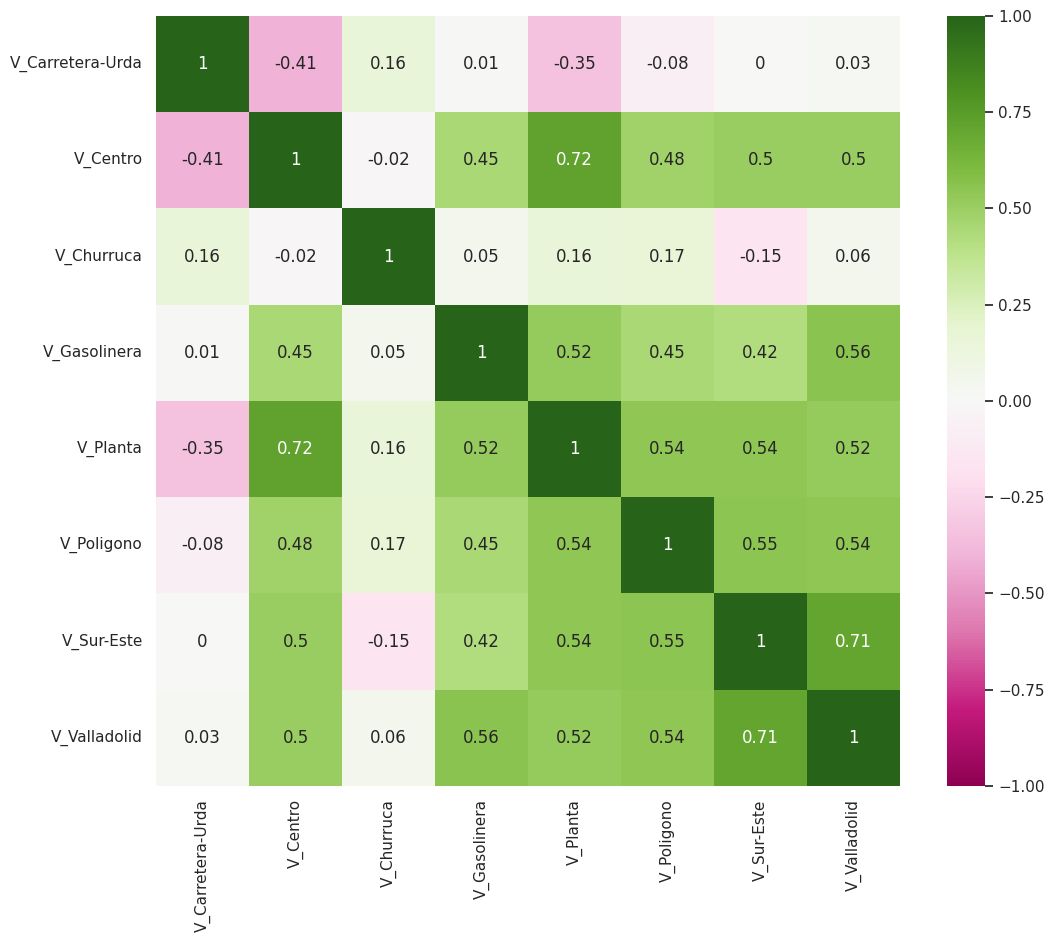

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(3,11))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

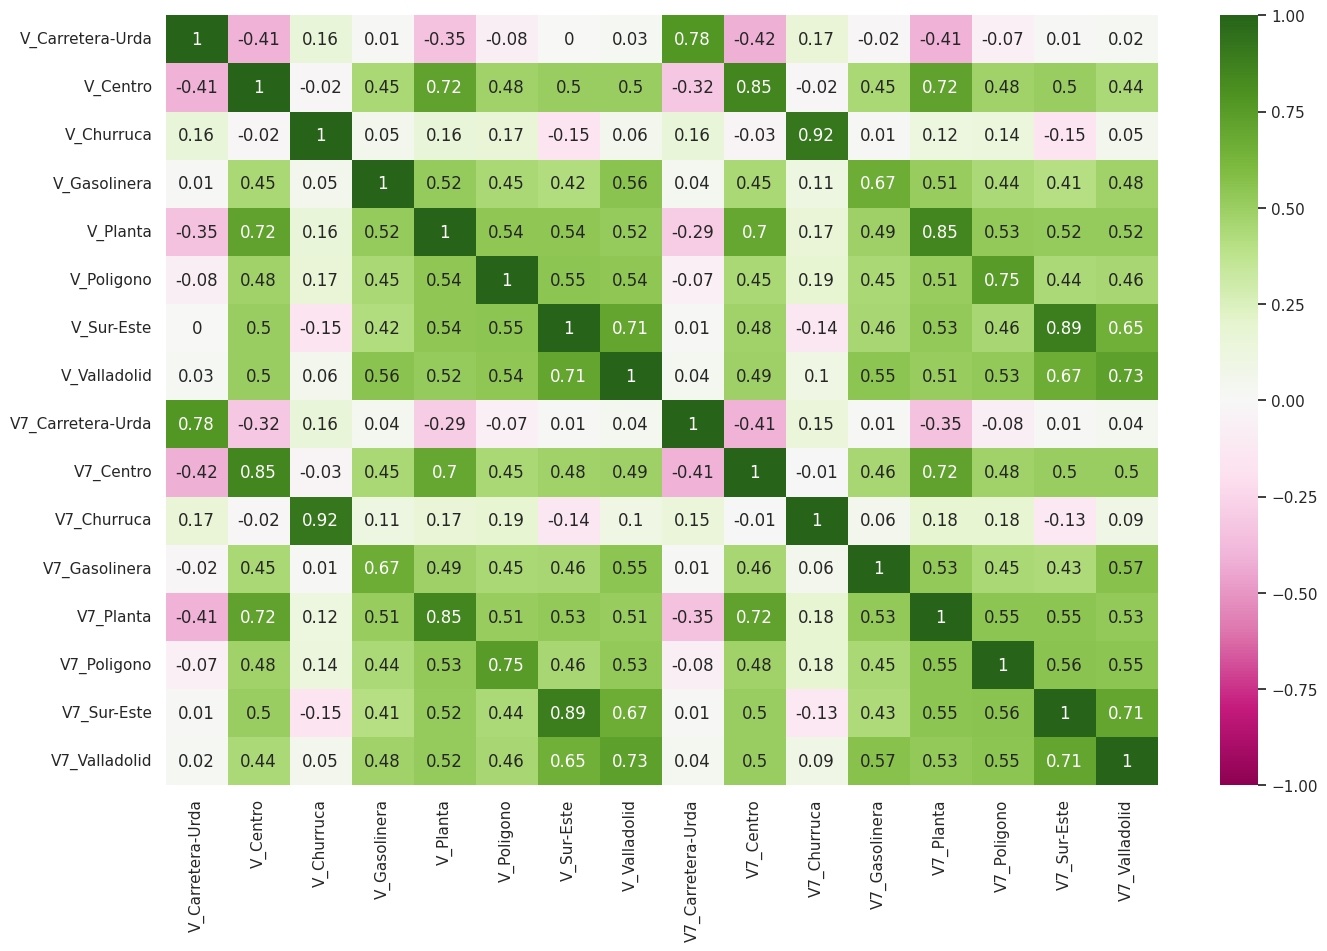

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})
cols = list(range(3,11)) + list(range(33,41))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

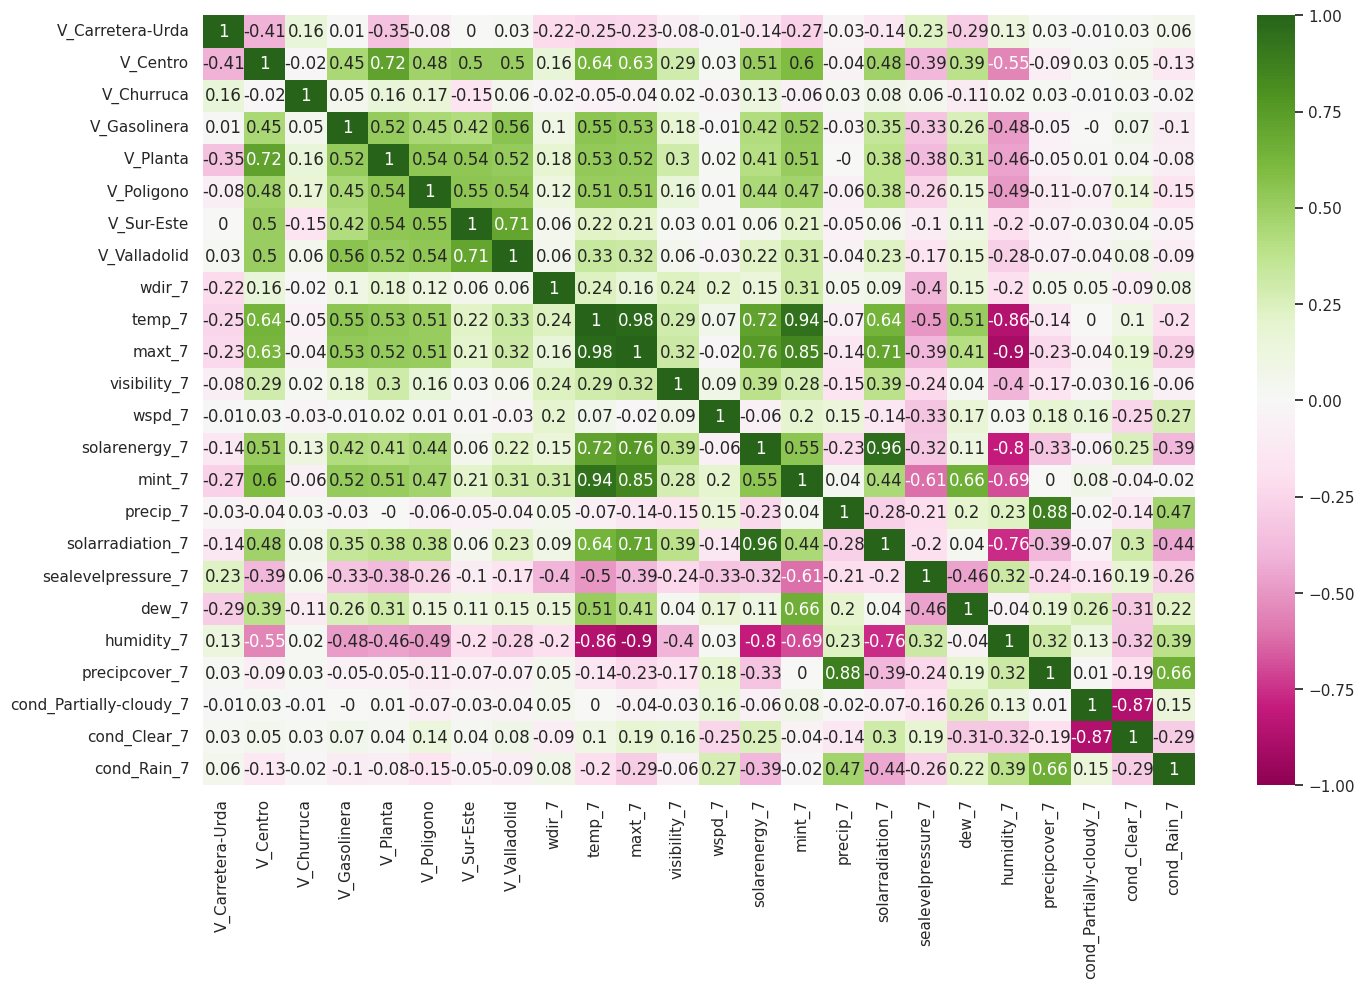

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})
cols = list(range(3,11)) + list(range(41,57))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

In [ ]:
df_encshift.columns

Index(['RowKey', 'RowKey_Date', 'RowKey_Time', 'V_Carretera-Urda', 'V_Centro',
       'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este',
       'V_Valladolid', 'DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes',
       'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
       'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable',
       'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'N_DiaMes', 'N_Mes',
       'N_Ano', 'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS',
       'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS', 'V7_Carretera-Urda',
       'V7_Centro', 'V7_Churruca', 'V7_Gasolinera', 'V7_Planta', 'V7_Poligono',
       'V7_Sur-Este', 'V7_Valladolid', 'wdir_7', 'temp_7', 'maxt_7',
       'visibility_7', 'wspd_7', 'solarenergy_7', 'mint_7', 'precip_7',
       'solarradiation_7', 'sealevelpressure_7', 'dew_7', 'humidity_7',
       'precipcover_7', 'cond_Partially-cloudy_7', 'cond_Clear_7',
       'cond_Rain_7', 'cond_Overcast_7'],
    

In [ ]:
sel_cols = ['V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
            'V7_Carretera-Urda', 'V7_Centro', 'V7_Churruca', 'V7_Gasolinera', 'V7_Planta', 'V7_Poligono', 'V7_Sur-Este', 'V7_Valladolid',
            'wdir_7', 'temp_7', 'maxt_7', 'visibility_7', 'solarenergy_7', 'mint_7', 'solarradiation_7', 'sealevelpressure_7', 'dew_7', 'humidity_7',
            'N_Mes', 'N_Ano', 'Mes_SIN', 'Mes_COS']

In [ ]:
df_sel = df_encshift[sel_cols].copy()
df_sel

,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,V_Valladolid,V7_Carretera-Urda,V7_Centro,...,solarenergy_7,mint_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,N_Mes,N_Ano,Mes_SIN,Mes_COS
0,0.4399,1.7500,11.1250,1.9400,2.6875,1.7506,4.9375,9.7500,1.1001,1.5938,...,24.4000,14.2000,452.7000,"1,014.1000",3.8000,27.8700,8,2021,-0.5000,-0.8660
1,0.5200,1.8125,10.8750,1.8100,2.5625,1.7081,4.8750,9.3125,1.2300,1.6562,...,24.4000,14.2000,452.7000,"1,014.1000",3.8000,27.8700,8,2021,-0.5000,-0.8660
2,0.3901,1.5937,10.3750,1.7200,2.5625,1.5100,4.5625,8.9375,1.1099,1.6250,...,24.4000,14.2000,452.7000,"1,014.1000",3.8000,27.8700,8,2021,-0.5000,-0.8660
3,0.4302,1.4375,10.3125,1.7000,2.3125,1.4675,4.3750,8.3750,1.1299,1.6875,...,24.4000,14.2000,452.7000,"1,014.1000",3.8000,27.8700,8,2021,-0.5000,-0.8660
4,0.3599,1.4375,9.4375,1.7000,2.1250,1.4562,4.3125,8.3125,1.1304,1.4375,...,24.4000,14.2000,452.7000,"1,014.1000",3.8000,27.8700,8,2021,-0.5000,-0.8660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47035,0.1895,1.6406,6.5095,0.9300,2.6680,0.0025,8.2500,9.9023,0.2305,1.8594,...,8.0000,5.0000,222.2000,"1,009.7000",6.4000,75.8000,12,2022,-0.5000,0.8660
47036,0.1602,1.6992,4.1387,0.9200,2.2227,0.3442,8.0000,9.3008,0.2500,1.8008,...,8.0000,5.0000,222.2000,"1,009.7000",6.4000,75.8000,12,2022,-0.5000,0.8660
47037,0.1699,1.7500,2.8325,0.6800,2.1992,0.4152,7.5000,8.6992,0.2695,1.5078,...,8.0000,5.0000,222.2000,"1,009.7000",6.4000,75.8000,12,2022,-0.5000,0.8660
47038,0.1699,1.6406,2.2161,0.6800,2.2109,0.3209,7.3750,8.5000,0.1895,1.4688,...,8.0000,5.0000,222.2000,"1,009.7000",6.4000,75.8000,12,2022,-0.5000,0.8660


<Axes: >

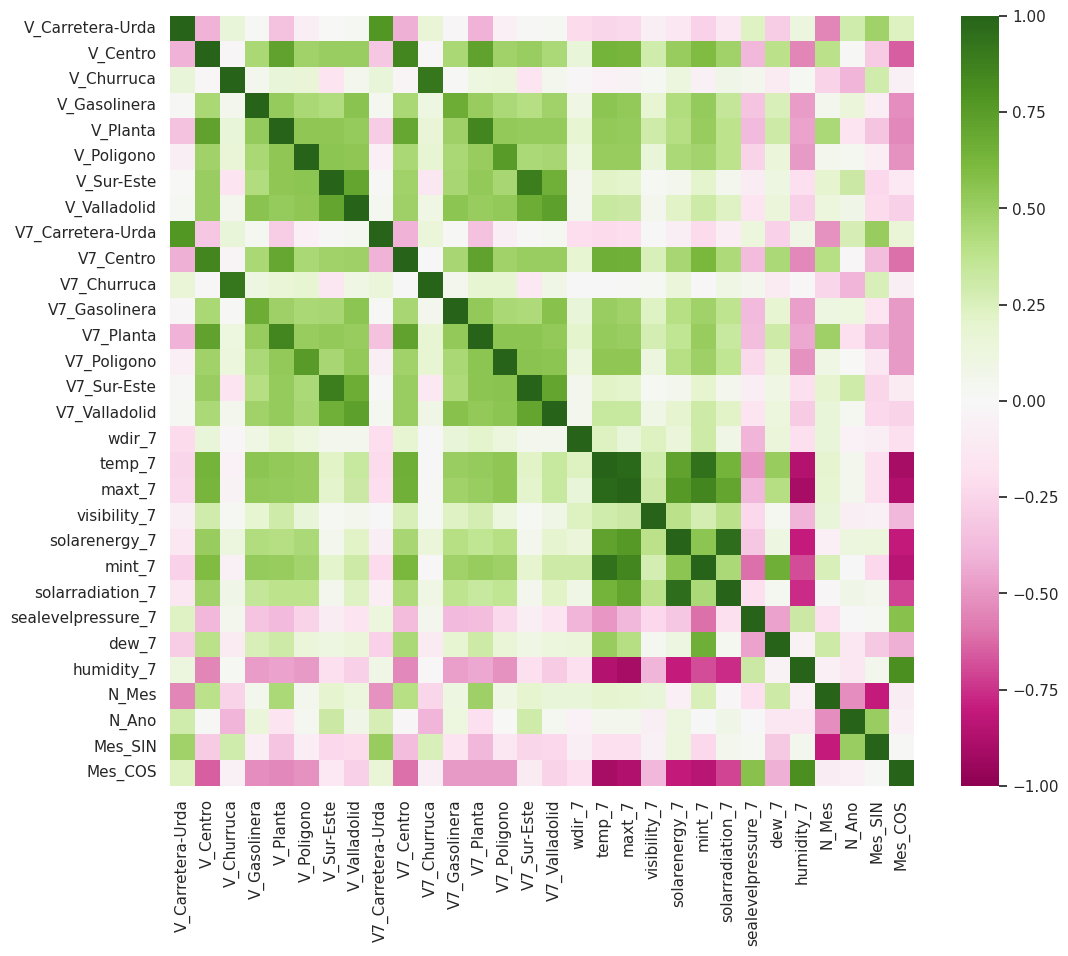

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
df_corr = df_sel.copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=False, cmap="PiYG")

## 2. ML MODEL: XGBOOST

### MODEL 1 - DAILY PREDICTION

#### Target & Predictor variables

In [ ]:
df_model = df_encshift.copy()
df_model

,RowKey,RowKey_Date,RowKey_Time,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono,V_Sur-Este,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,2021-08-09 00:15:00+00:00,2021-08-09,00:15:00,0.4399,1.7500,11.1250,1.9400,2.6875,1.7506,4.9375,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
1,2021-08-09 00:30:00+00:00,2021-08-09,00:30:00,0.5200,1.8125,10.8750,1.8100,2.5625,1.7081,4.8750,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
2,2021-08-09 00:45:00+00:00,2021-08-09,00:45:00,0.3901,1.5937,10.3750,1.7200,2.5625,1.5100,4.5625,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
3,2021-08-09 01:00:00+00:00,2021-08-09,01:00:00,0.4302,1.4375,10.3125,1.7000,2.3125,1.4675,4.3750,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
4,2021-08-09 01:15:00+00:00,2021-08-09,01:15:00,0.3599,1.4375,9.4375,1.7000,2.1250,1.4562,4.3125,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47035,2022-12-11 23:00:00+00:00,2022-12-11,23:00:00,0.1895,1.6406,6.5095,0.9300,2.6680,0.0025,8.2500,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47036,2022-12-11 23:15:00+00:00,2022-12-11,23:15:00,0.1602,1.6992,4.1387,0.9200,2.2227,0.3442,8.0000,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47037,2022-12-11 23:30:00+00:00,2022-12-11,23:30:00,0.1699,1.7500,2.8325,0.6800,2.1992,0.4152,7.5000,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000
47038,2022-12-11 23:45:00+00:00,2022-12-11,23:45:00,0.1699,1.6406,2.2161,0.6800,2.2109,0.3209,7.3750,...,0.0000,222.2000,"1,009.7000",6.4000,75.8000,0.0000,1.0000,0.0000,0.0000,0.0000


In [ ]:
target_cols = [x for x in list(df_model.columns) if x.startswith('V_')]
#target_cols = list(set(target_cols) - set(untarget_cols))
target_cols

['V_Carretera-Urda',
 'V_Centro',
 'V_Churruca',
 'V_Gasolinera',
 'V_Planta',
 'V_Poligono',
 'V_Sur-Este',
 'V_Valladolid']

In [ ]:
unselect_comvars = []

try:
  print(filter_dict['V_Carretera-Urda'])

except:
  filter_dict = {'V_Carretera-Urda' : [],
                 'V_Valladolid' : [],
                 'V_Poligono' : [],
                 'V_Planta' : [],
                 'V_Centro' : [],
                 'V_Sur-Este' : [],
                 'V_Churruca' : [],
                 'V_Gasolinera' : []
                }

  print('"filter_dict" created')


['DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes', 'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes', 'Clasif_Lab_No Laborable', 'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'N_DiaMes', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'V7_Centro', 'V7_Churruca', 'V7_Gasolinera', 'V7_Poligono', 'V7_Sur-Este', 'V7_Valladolid', 'wdir_7', 'maxt_7', 'visibility_7', 'wspd_7', 'solarenergy_7', 'precip_7', 'solarradiation_7', 'sealevelpressure_7', 'dew_7', 'precipcover_7', 'cond_Partially-cloudy_7', 'cond_Clear_7', 'cond_Rain_7', 'cond_Overcast_7']


In [ ]:

data_cols = list(df_model.columns)
cat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)
select_dict = {}

for x in target_cols:
  del_cols = list(target_cols + unselect_comvars + filter_dict[x] + cat_vars)
  select_vars = [x for x in list(df_model.columns) if x not in del_cols]
  select_dict[x] = select_vars

print(select_dict.keys())
print(select_dict[x][:10])


dict_keys(['V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid'])
['N_DiaMes', 'N_Mes', 'N_Ano', 'DiaSem_COS', 'Dia_SIN', 'Mes_SIN', 'Mes_COS', 'V7_Sur-Este', 'V7_Valladolid', 'temp_7']


#### Test dates

In [ ]:

#start_date = dt.date(2022, 12, 1)
start_date = dt.date(2022, 12, 3)
end_date = dt.date(2022, 12, 3)    # perhaps date.now()
delta = end_date - start_date   # returns timedelta

test_dates = []
i = 0

for x in range(delta.days + 1):
  day = start_date + dt.timedelta(days=x)
  test_dates.append(str(day))

test_dates[:5]


['2022-12-03']

#### Model definition

In [ ]:
ML_model = XGBRegressor(objective='reg:tweedie',nthread=-1, verbosity=1)  # n_estimators=100, max_depth=6, eta=0.3

In [ ]:
train_dict = {}
test_dict = {}

for x in target_cols:

  train_dict[x] = {}
  test_dict[x] = {}

  print('\n')
  print(f'Model XGBoost (Sector "{x}")')
  print('_'*70)

  for y in test_dates:

    day = dt.datetime.strptime(y, '%Y-%m-%d')
    y7 = str(day + dt.timedelta(days=6))

    start = time.time()

    X_train = df_model[(df_model['RowKey_Date']<y)][select_dict[x]]
    y_train = df_model[(df_model['RowKey_Date']<y)][x].copy()
    y_train.reset_index(drop=True, inplace=True)
    y_train.rename("y_true", inplace=True)

    X_test = df_model[(df_model['RowKey_Date']>=y)&(df_model['RowKey_Date']<=y7)][select_dict[x]]
    y_test = df_model[(df_model['RowKey_Date']>=y)&(df_model['RowKey_Date']<=y7)][x].copy()
    y_test.reset_index(drop=True, inplace=True)
    y_test.rename("y_true", inplace=True)

    ML_model.fit(X_train, y_train)
    y_trainpred = pd.DataFrame(ML_model.predict(X_train), columns=['y_pred'])
    y_testpred = pd.DataFrame(ML_model.predict(X_test), columns=['y_pred'])

    df_auxtrain = df_model[(df_model['RowKey_Date']<y)][['RowKey','RowKey_Date','RowKey_Time']].copy()
    df_auxtrain.reset_index(drop=True, inplace=True)
    train_res = pd.concat([df_auxtrain, y_train, y_trainpred], axis=1)
    df_auxtest = df_model[(df_model['RowKey_Date']>=y)&(df_model['RowKey_Date']<=y7)][['RowKey','RowKey_Date','RowKey_Time']].copy()
    df_auxtest.reset_index(drop=True, inplace=True)
    test_res = pd.concat([df_auxtest, y_test, y_testpred], axis=1).reset_index(drop=True)
    train_dict[x][y] = train_res
    test_dict[x][y] = test_res

    df_aux = pd.DataFrame(columns=['STA_Label','RowKey_Date'])
    #df_aux = pd.DataFrame(columns=cols)
    df_aux = pd.concat([df_aux, pd.DataFrame(ML_model.feature_importances_, index=select_dict[x]).transpose()], axis=1)
    df_aux.loc[:,'STA_Label'] = x
    df_aux.loc[:,'RowKey_Date'] = y

    if target_cols.index(x)==0 and test_dates.index(y)==0:
      imp_df = df_aux.copy()
    else:
      imp_df = pd.concat([imp_df, df_aux], axis=0)
      #imp_df = pd.concat([imp_df, df_aux], axis=0)
      imp_df.reset_index(drop=True,inplace=True)
      imp_df

    end = time.time()
    #print('_'*35)
    print(f'-Test {y} ({timedelta(minutes=end-start)}))')
    #print('\n')




Model XGBoost (Sector "V_Carretera-Urda")
______________________________________________________________________
-Test 2022-12-03 (0:02:57.442517))


Model XGBoost (Sector "V_Centro")
______________________________________________________________________
-Test 2022-12-03 (0:05:33.599539))


Model XGBoost (Sector "V_Churruca")
______________________________________________________________________
-Test 2022-12-03 (0:01:49.367194))


Model XGBoost (Sector "V_Gasolinera")
______________________________________________________________________
-Test 2022-12-03 (0:02:07.582898))


Model XGBoost (Sector "V_Planta")
______________________________________________________________________
-Test 2022-12-03 (0:01:50.241365))


Model XGBoost (Sector "V_Poligono")
______________________________________________________________________
-Test 2022-12-03 (0:01:15.797067))


Model XGBoost (Sector "V_Sur-Este")
______________________________________________________________________
-Test 2022-12-03 (0:01:

#### Feature importance

In [ ]:
cols = ['STA_Label'] + [x for x in list(df_model.columns) if x in list(imp_df.columns)]
imp_df = imp_df[cols]
imp_df

,STA_Label,RowKey_Date,DiaSem_Viernes,Clasif_Lab_Laborable,Clasif_Fest_Festivo,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,Lab_PostFest,...,V7_Valladolid,temp_7,maxt_7,visibility_7,wspd_7,solarenergy_7,mint_7,precip_7,solarradiation_7,humidity_7
0,V_Carretera-Urda,2022-12-03,NaN,0.0311,NaN,NaN,0.0558,0.0844,0.0463,NaN,...,NaN,0.0409,NaN,NaN,NaN,NaN,0.1031,NaN,NaN,0.0660
1,V_Centro,2022-12-03,NaN,NaN,NaN,0.0297,0.7097,0.1387,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,V_Churruca,2022-12-03,NaN,NaN,NaN,NaN,NaN,0.4708,NaN,NaN,...,NaN,0.0459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,V_Gasolinera,2022-12-03,NaN,NaN,0.2964,NaN,0.0472,0.0538,NaN,0.0348,...,NaN,0.0794,NaN,NaN,0.0208,0.0243,0.0265,NaN,0.0482,0.0309
4,V_Planta,2022-12-03,NaN,NaN,NaN,0.0768,0.7470,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,V_Poligono,2022-12-03,NaN,0.0582,NaN,NaN,NaN,0.0602,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0674,NaN,NaN,NaN,NaN
6,V_Sur-Este,2022-12-03,0.0330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0407,NaN,NaN
7,V_Valladolid,2022-12-03,NaN,NaN,NaN,0.0368,0.1202,0.0955,NaN,NaN,...,0.1242,0.0350,0.0490,0.0398,NaN,0.0696,0.0762,NaN,NaN,NaN


In [ ]:
imp_df.iloc[:,range(0,16)].groupby('STA_Label').mean()

<ipython-input-148-5822dc9c7b23>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,DiaSem_Viernes,Clasif_Lab_Laborable,Clasif_Fest_Festivo,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,Lab_PostFest,DiaSem_COS,Dia_SIN,Dia_COS,Mes_SIN,Mes_COS,V7_Carretera-Urda
STA_Label,,,,,,,,,,,,,,
V_Carretera-Urda,NaN,0.0311,NaN,NaN,0.0558,0.0844,0.0463,NaN,NaN,NaN,0.0631,0.1183,0.1236,0.2314
V_Centro,NaN,NaN,NaN,0.0297,0.7097,0.1387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V_Churruca,NaN,NaN,NaN,NaN,NaN,0.4708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V_Gasolinera,NaN,NaN,0.2964,NaN,0.0472,0.0538,NaN,0.0348,NaN,0.0164,NaN,NaN,0.2295,NaN
V_Planta,NaN,NaN,NaN,0.0768,0.7470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V_Poligono,NaN,0.0582,NaN,NaN,NaN,0.0602,NaN,NaN,NaN,NaN,NaN,NaN,0.2605,NaN
V_Sur-Este,0.0330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0387,NaN
V_Valladolid,NaN,NaN,NaN,0.0368,0.1202,0.0955,NaN,NaN,0.0343,0.0765,NaN,0.1396,0.0781,NaN


In [ ]:
imp_df.iloc[:,list(range(0,2))+list(range(16,27))].groupby('STA_Label').mean()

<ipython-input-149-6f11acf05eaa>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,V7_Centro,V7_Churruca,V7_Gasolinera,V7_Planta,V7_Poligono,V7_Sur-Este,V7_Valladolid,temp_7,maxt_7,visibility_7,wspd_7
STA_Label,,,,,,,,,,,
V_Carretera-Urda,NaN,NaN,NaN,0.0361,NaN,NaN,NaN,0.0409,NaN,NaN,NaN
V_Centro,0.1219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V_Churruca,NaN,0.4834,NaN,NaN,NaN,NaN,NaN,0.0459,NaN,NaN,NaN
V_Gasolinera,NaN,NaN,0.0919,NaN,NaN,NaN,NaN,0.0794,NaN,NaN,0.0208
V_Planta,NaN,NaN,NaN,0.1763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V_Poligono,NaN,NaN,NaN,NaN,0.5537,NaN,NaN,NaN,NaN,NaN,NaN
V_Sur-Este,NaN,NaN,NaN,NaN,NaN,0.8876,NaN,NaN,NaN,NaN,NaN
V_Valladolid,NaN,NaN,NaN,NaN,NaN,0.0252,0.1242,0.0350,0.0490,0.0398,NaN


In [ ]:
imp_df.iloc[:,list(range(0,2))+list(range(27,30))].groupby('STA_Label').mean()

<ipython-input-150-63e8de18a15c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,solarenergy_7,mint_7,precip_7
STA_Label,,,
V_Carretera-Urda,NaN,0.1031,NaN
V_Centro,NaN,NaN,NaN
V_Churruca,NaN,NaN,NaN
V_Gasolinera,0.0243,0.0265,NaN
V_Planta,NaN,NaN,NaN
V_Poligono,0.0674,NaN,NaN
V_Sur-Este,NaN,NaN,0.0407
V_Valladolid,0.0696,0.0762,NaN


In [ ]:

impgroup_df = imp_df.groupby('STA_Label').mean()
#impgroup_df.reset_index(drop=True, inplace=True)

for x in target_cols:
  filter_vars = filter_dict[x]

  for y in list(impgroup_df.columns):
    imp_value = impgroup_df.loc[x,y]

    if imp_value < 0.02:
      filter_vars.append(y)

  filter_dict[x] = filter_vars


<ipython-input-151-f84f517c90b7>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [ ]:
filter_dict

{'V_Carretera-Urda': ['DiaSem_Domingo',
  'DiaSem_Jueves',
  'DiaSem_Lunes',
  'DiaSem_Martes',
  'DiaSem_Miercoles',
  'DiaSem_Sabado',
  'DiaSem_Viernes',
  'Clasif_Lab_No Laborable',
  'Clasif_Fest_Festivo',
  'Clasif_Fest_No Festivo',
  'N_DiaMes',
  'Lab_PostFest',
  'DiaSem_SIN',
  'DiaSem_COS',
  'Dia_SIN',
  'V7_Centro',
  'V7_Churruca',
  'V7_Gasolinera',
  'V7_Poligono',
  'V7_Sur-Este',
  'V7_Valladolid',
  'wdir_7',
  'maxt_7',
  'visibility_7',
  'wspd_7',
  'solarenergy_7',
  'precip_7',
  'solarradiation_7',
  'sealevelpressure_7',
  'dew_7',
  'precipcover_7',
  'cond_Partially-cloudy_7',
  'cond_Clear_7',
  'cond_Rain_7',
  'cond_Overcast_7'],
 'V_Valladolid': ['DiaSem_Domingo',
  'DiaSem_Jueves',
  'DiaSem_Lunes',
  'DiaSem_Martes',
  'DiaSem_Miercoles',
  'DiaSem_Sabado',
  'Clasif_Lab_Laborable',
  'Clasif_Lab_No Laborable',
  'Clasif_Fest_Festivo',
  'Clasif_Fest_No Festivo',
  'Lab_PrevioFest',
  'Lab_PostFest',
  'DiaSem_SIN',
  'Dia_COS',
  'V7_Carretera-Urda',


In [ ]:
i = 0

for x in list(filter_dict.keys()):

  if i==0:
    set_aux = set(filter_dict[x])
  else:
    set_x = set(filter_dict[x])
    set_aux = set_aux.intersection(set_x)

  #print(filter_dict[x])
  i += 1


In [ ]:
set_aux

{'Clasif_Fest_No Festivo',
 'Clasif_Lab_No Laborable',
 'DiaSem_Domingo',
 'DiaSem_Jueves',
 'DiaSem_Lunes',
 'DiaSem_Martes',
 'DiaSem_Miercoles',
 'DiaSem_SIN',
 'DiaSem_Sabado',
 'cond_Clear_7',
 'cond_Overcast_7',
 'cond_Partially-cloudy_7',
 'cond_Rain_7',
 'dew_7',
 'precipcover_7',
 'sealevelpressure_7',
 'wdir_7'}

#### Train/Test scores

In [ ]:
train_dict.keys()

dict_keys(['V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid'])

In [ ]:
train_dict['V_Carretera-Urda']['2022-12-03']

,RowKey,RowKey_Date,RowKey_Time,y_true,y_pred
0,2021-08-09 00:15:00+00:00,2021-08-09,00:15:00,0.4399,0.3284
1,2021-08-09 00:30:00+00:00,2021-08-09,00:30:00,0.5200,0.3223
2,2021-08-09 00:45:00+00:00,2021-08-09,00:45:00,0.3901,0.3284
3,2021-08-09 01:00:00+00:00,2021-08-09,01:00:00,0.4302,0.3713
4,2021-08-09 01:15:00+00:00,2021-08-09,01:15:00,0.3599,0.2959
...,...,...,...,...,...
46171,2022-12-02 23:00:00+00:00,2022-12-02,23:00:00,0.1602,0.2485
46172,2022-12-02 23:15:00+00:00,2022-12-02,23:15:00,0.2109,0.2414
46173,2022-12-02 23:30:00+00:00,2022-12-02,23:30:00,0.1992,0.2338
46174,2022-12-02 23:45:00+00:00,2022-12-02,23:45:00,0.2012,0.1685


In [ ]:
test_dict.keys()

dict_keys(['V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid'])

In [ ]:
test_dict['V_Carretera-Urda']['2022-12-03']

,RowKey,RowKey_Date,RowKey_Time,y_true,y_pred
0,2022-12-03 00:15:00+00:00,2022-12-03,00:15:00,0.1602,0.1348
1,2022-12-03 00:30:00+00:00,2022-12-03,00:30:00,0.1816,0.1324
2,2022-12-03 00:45:00+00:00,2022-12-03,00:45:00,0.1484,0.1183
3,2022-12-03 01:00:00+00:00,2022-12-03,01:00:00,0.1602,0.1052
4,2022-12-03 01:15:00+00:00,2022-12-03,01:15:00,0.2012,0.1183
...,...,...,...,...,...
667,2022-12-09 23:00:00+00:00,2022-12-09,23:00:00,0.2207,0.1528
668,2022-12-09 23:15:00+00:00,2022-12-09,23:15:00,0.2793,0.1420
669,2022-12-09 23:30:00+00:00,2022-12-09,23:30:00,0.1602,0.1508
670,2022-12-09 23:45:00+00:00,2022-12-09,23:45:00,0.1797,0.1189


In [ ]:
test_dict['V_Carretera-Urda']['2022-12-03']['RowKey_Date'].unique()

array(['2022-12-03T00:00:00.000000000', '2022-12-04T00:00:00.000000000',
       '2022-12-05T00:00:00.000000000', '2022-12-06T00:00:00.000000000',
       '2022-12-07T00:00:00.000000000', '2022-12-08T00:00:00.000000000',
       '2022-12-09T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
target_cols[:5]

['V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta']

In [ ]:
test_dates[:5]

['2022-12-03']

In [ ]:

df_scores = pd.DataFrame(columns=['STA_Label', 'RowKey_Date', 'Train_MAPE','Train_MAE','Train_RMSE','Test_MAPE','Test_MAE','Test_RMSE'])
i = 0

for x in target_cols:
  for y in test_dates:

    df_scores.loc[i,'STA_Label'] = x
    df_scores.loc[i,'RowKey_Date'] = y

    # TRAIN SCORES
    y_true = train_dict[x][y].loc[:,'y_true']
    y_pred = train_dict[x][y].loc[:,'y_pred']
    #mape = round(mean_absolute_percentage_error(y_true, y_pred), 4)
    mape = round(mape_corr(y_true, y_pred), 4)
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 4)

    df_scores.loc[i,'Train_MAPE'] = mape
    df_scores.loc[i,'Train_MAE'] = mae
    df_scores.loc[i,'Train_RMSE'] = rmse

    # TEST SCORES
    y_true = test_dict[x][y].loc[:,'y_true']
    y_pred = test_dict[x][y].loc[:,'y_pred']
    #mape = round(mean_absolute_percentage_error(y_true, y_pred), 4)
    mape = round(mape_corr(y_true, y_pred), 4)
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 4)

    df_scores.loc[i,'Test_MAPE'] = mape
    df_scores.loc[i,'Test_MAE'] = mae
    df_scores.loc[i,'Test_RMSE'] = rmse

    i += 1


In [ ]:
df_scores

,STA_Label,RowKey_Date,Train_MAPE,Train_MAE,Train_RMSE,Test_MAPE,Test_MAE,Test_RMSE
0,V_Carretera-Urda,2022-12-03,0,0.1003,0.1675,0.3069,0.0686,0.1025
1,V_Centro,2022-12-03,0,0.1624,0.2795,0.1475,0.2568,0.3245
2,V_Churruca,2022-12-03,0,0.6629,1.1884,0,1.3266,2.4540
3,V_Gasolinera,2022-12-03,0,0.1344,0.2275,0.1957,0.2127,0.2791
4,V_Planta,2022-12-03,0,0.3564,0.6591,0,0.4938,0.7464
5,V_Poligono,2022-12-03,0,0.2082,0.3603,0.1950,0.1366,0.2104
6,V_Sur-Este,2022-12-03,0,0.5989,0.9613,0.1483,1.4512,1.9343
7,V_Valladolid,2022-12-03,0,0.5988,1.0003,0.1071,1.2437,1.9326


In [ ]:
final_scores = df_scores.groupby('STA_Label').mean().reset_index()
final_scores

<ipython-input-164-99a6e135f461>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,STA_Label,Train_MAPE,Train_MAE,Train_RMSE,Test_MAPE,Test_MAE,Test_RMSE
0,V_Carretera-Urda,0.0000,0.1003,0.1675,0.3069,0.0686,0.1025
1,V_Centro,0.0000,0.1624,0.2795,0.1475,0.2568,0.3245
2,V_Churruca,0.0000,0.6629,1.1884,0.0000,1.3266,2.4540
3,V_Gasolinera,0.0000,0.1344,0.2275,0.1957,0.2127,0.2791
4,V_Planta,0.0000,0.3564,0.6591,0.0000,0.4938,0.7464
5,V_Poligono,0.0000,0.2082,0.3603,0.1950,0.1366,0.2104
6,V_Sur-Este,0.0000,0.5989,0.9613,0.1483,1.4512,1.9343
7,V_Valladolid,0.0000,0.5988,1.0003,0.1071,1.2437,1.9326


In [ ]:
df_model.iloc[:,range(0,9)].describe()

,V_Carretera-Urda,V_Centro,V_Churruca,V_Gasolinera,V_Planta,V_Poligono
count,"47,040.0000","47,040.0000","47,040.0000","47,040.0000","47,040.0000","47,040.0000"
mean,0.4863,1.5397,9.0121,1.5151,2.9663,1.0274
std,0.6961,1.1372,6.4891,0.9942,2.2148,0.7341
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0698,0.2946,1.3019,0.8900,1.3400,0.5450
50%,0.1699,1.6875,9.7500,1.3100,3.1199,0.7600
75%,0.5293,2.3594,14.0625,1.9400,4.5400,1.3064
max,4.9800,8.4023,31.5000,8.6100,17.4805,7.9275


In [ ]:

for x in target_cols:
  for y in test_dates:

    df_train = train_dict[x][y]
    df_train.insert(0, "STA_Label", x)
    df_test = test_dict[x][y]
    df_test.insert(0, "STA_Label", x)

    if target_cols.index(x)==0 and test_dates.index(y)==0:
      preds_train = df_train.copy()
      preds_test = df_test.copy()
    else:
      preds_train = pd.concat([preds_train, df_train], axis=0)
      preds_train.reset_index(drop=True,inplace=True)

      preds_test = pd.concat([preds_test, df_test], axis=0)
      preds_test.reset_index(drop=True,inplace=True)

preds_train['resid'] = preds_train['y_pred'] - preds_train['y_true']
preds_test['resid'] = preds_test['y_pred'] - preds_test['y_true']

In [ ]:
preds_train

,STA_Label,RowKey,RowKey_Date,RowKey_Time,y_true,y_pred,resid
0,V_Carretera-Urda,2021-08-09 00:15:00+00:00,2021-08-09,00:15:00,0.4399,0.3284,-0.1115
1,V_Carretera-Urda,2021-08-09 00:30:00+00:00,2021-08-09,00:30:00,0.5200,0.3223,-0.1977
2,V_Carretera-Urda,2021-08-09 00:45:00+00:00,2021-08-09,00:45:00,0.3901,0.3284,-0.0617
3,V_Carretera-Urda,2021-08-09 01:00:00+00:00,2021-08-09,01:00:00,0.4302,0.3713,-0.0589
4,V_Carretera-Urda,2021-08-09 01:15:00+00:00,2021-08-09,01:15:00,0.3599,0.2959,-0.0640
...,...,...,...,...,...,...,...
369403,V_Valladolid,2022-12-02 23:00:00+00:00,2022-12-02,23:00:00,10.4023,10.3556,-0.0467
369404,V_Valladolid,2022-12-02 23:15:00+00:00,2022-12-02,23:15:00,10.0977,9.6645,-0.4332
369405,V_Valladolid,2022-12-02 23:30:00+00:00,2022-12-02,23:30:00,9.6992,9.9429,0.2437
369406,V_Valladolid,2022-12-02 23:45:00+00:00,2022-12-02,23:45:00,9.1016,9.4204,0.3188


In [ ]:
preds_train[(preds_train['resid']<-10)|(preds_train['resid']>10)]

,STA_Label,RowKey,RowKey_Date,RowKey_Time,y_true,y_pred,resid
93151,V_Churruca,2021-08-17 08:00:00+00:00,2021-08-17,08:00:00,21.5000,11.1404,-10.3596
93167,V_Churruca,2021-08-17 12:00:00+00:00,2021-08-17,12:00:00,7.8125,19.1063,11.2938
93168,V_Churruca,2021-08-17 12:15:00+00:00,2021-08-17,12:15:00,0.0000,18.6540,18.6540
93169,V_Churruca,2021-08-17 12:30:00+00:00,2021-08-17,12:30:00,0.1875,18.6540,18.4665
93170,V_Churruca,2021-08-17 12:45:00+00:00,2021-08-17,12:45:00,3.8125,18.4756,14.6631
...,...,...,...,...,...,...,...
366008,V_Valladolid,2022-10-28 14:15:00+00:00,2022-10-28,14:15:00,0.0000,10.5634,10.5634
366009,V_Valladolid,2022-10-28 14:30:00+00:00,2022-10-28,14:30:00,0.0000,10.5668,10.5668
366010,V_Valladolid,2022-10-28 14:45:00+00:00,2022-10-28,14:45:00,0.0000,11.3766,11.3766
366032,V_Valladolid,2022-10-28 20:15:00+00:00,2022-10-28,20:15:00,13.8000,3.6530,-10.1471


In [ ]:
preds_test

,STA_Label,RowKey,RowKey_Date,RowKey_Time,y_true,y_pred,resid
0,V_Carretera-Urda,2022-12-03 00:15:00+00:00,2022-12-03,00:15:00,0.1602,0.1348,-0.0254
1,V_Carretera-Urda,2022-12-03 00:30:00+00:00,2022-12-03,00:30:00,0.1816,0.1324,-0.0492
2,V_Carretera-Urda,2022-12-03 00:45:00+00:00,2022-12-03,00:45:00,0.1484,0.1183,-0.0302
3,V_Carretera-Urda,2022-12-03 01:00:00+00:00,2022-12-03,01:00:00,0.1602,0.1052,-0.0549
4,V_Carretera-Urda,2022-12-03 01:15:00+00:00,2022-12-03,01:15:00,0.2012,0.1183,-0.0829
...,...,...,...,...,...,...,...
5371,V_Valladolid,2022-12-09 23:00:00+00:00,2022-12-09,23:00:00,10.6016,10.3403,-0.2612
5372,V_Valladolid,2022-12-09 23:15:00+00:00,2022-12-09,23:15:00,10.3984,10.4328,0.0344
5373,V_Valladolid,2022-12-09 23:30:00+00:00,2022-12-09,23:30:00,10.0000,10.1110,0.1110
5374,V_Valladolid,2022-12-09 23:45:00+00:00,2022-12-09,23:45:00,9.3984,8.9083,-0.4902


In [ ]:
preds_test[(preds_test['resid']<-10)|(preds_test['resid']>10)]

,STA_Label,RowKey,RowKey_Date,RowKey_Time,y_true,y_pred,resid
1378,V_Churruca,2022-12-03 08:45:00+00:00,2022-12-03,08:45:00,11.8078,0.3507,-11.4571
1474,V_Churruca,2022-12-04 08:45:00+00:00,2022-12-04,08:45:00,11.7100,0.3011,-11.4089
1475,V_Churruca,2022-12-04 09:00:00+00:00,2022-12-04,09:00:00,12.3203,0.0833,-12.2369
1476,V_Churruca,2022-12-04 09:15:00+00:00,2022-12-04,09:15:00,12.4403,0.0833,-12.3569
1477,V_Churruca,2022-12-04 09:30:00+00:00,2022-12-04,09:30:00,12.9155,0.0833,-12.8322
1666,V_Churruca,2022-12-06 08:45:00+00:00,2022-12-06,08:45:00,11.9581,0.4522,-11.5060
1667,V_Churruca,2022-12-06 09:00:00+00:00,2022-12-06,09:00:00,12.3179,1.1778,-11.1401
1681,V_Churruca,2022-12-06 12:30:00+00:00,2022-12-06,12:30:00,0.0000,10.0818,10.0818
1858,V_Churruca,2022-12-08 08:45:00+00:00,2022-12-08,08:45:00,12.0235,0.8612,-11.1623
1859,V_Churruca,2022-12-08 09:00:00+00:00,2022-12-08,09:00:00,11.8195,0.8612,-10.9583


In [ ]:
Train_MAPE = mape_corr(preds_train['y_true'], preds_train['y_pred'])*100
Train_MAE = mean_absolute_error(preds_train['y_true'], preds_train['y_pred'])
Train_RMSE = mean_squared_error(preds_train['y_true'], preds_train['y_pred'], squared=False)

Test_MAPE = mape_corr(preds_test['y_true'], preds_test['y_pred'])*100
Test_MAE = mean_absolute_error(preds_test['y_true'], preds_test['y_pred'])
Test_RMSE = mean_squared_error(preds_test['y_true'], preds_test['y_pred'], squared=False)

In [ ]:
mean_absolute_percentage_error(preds_test['y_true'], preds_test['y_pred'])*100

1.4014102290900154e+16

### Results

In [ ]:
print('Train scores:')
print(f'MAPE = {Train_MAPE:.4f} %')
print(f'MAE = {Train_MAE:.4f}')
print(f'RMSE = {Train_RMSE:.4f}')

print('Test scores:')
print(f'MAPE = {Test_MAPE:.4f} %')
print(f'MAE = {Test_MAE:.4f}')
print(f'RMSE = {Test_RMSE:.4f}')

Train scores:
MAPE = 0.0000 %
MAE = 0.3528
RMSE = 0.7123
Test scores:
MAPE = 0.0000 %
MAE = 0.6488
RMSE = 1.3367
